1. Model from Transfomerslibrary

In [2]:
import torch
from transformers import GPT2Config, GPT2Model

# Configure GPT-2 to output attentions
config = GPT2Config(
    n_layer=4,  # Number of layers
    n_head=4,   # Number of attention heads
    n_embd=128, # Embedding size
    output_attentions=True  # Enable attention outputs
)

# Load the model with this configuration
model = GPT2Model(config)

c:\Users\leonh\anaconda3\envs\adverserialAlignment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
input_ids = torch.randint(0, 50257, (1, 20))

# Forward pass
outputs = model(input_ids)

# Extract attention activations
attentions = outputs.attentions  # Tuple of attention weights
print(f"Number of layers with attentions: {len(attentions)}")

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Number of layers with attentions: 4


In [4]:
# Example: Inspect attention activations for layer 0
layer_0_attentions = attentions[0]
print(f"Shape of layer 0 attentions: {layer_0_attentions.shape}")

# Shape example: (1, 4, 20, 20)
# 1 batch, 4 attention heads, 20 tokens in sequence, attention for 20 tokens

Shape of layer 0 attentions: torch.Size([1, 4, 20, 20])


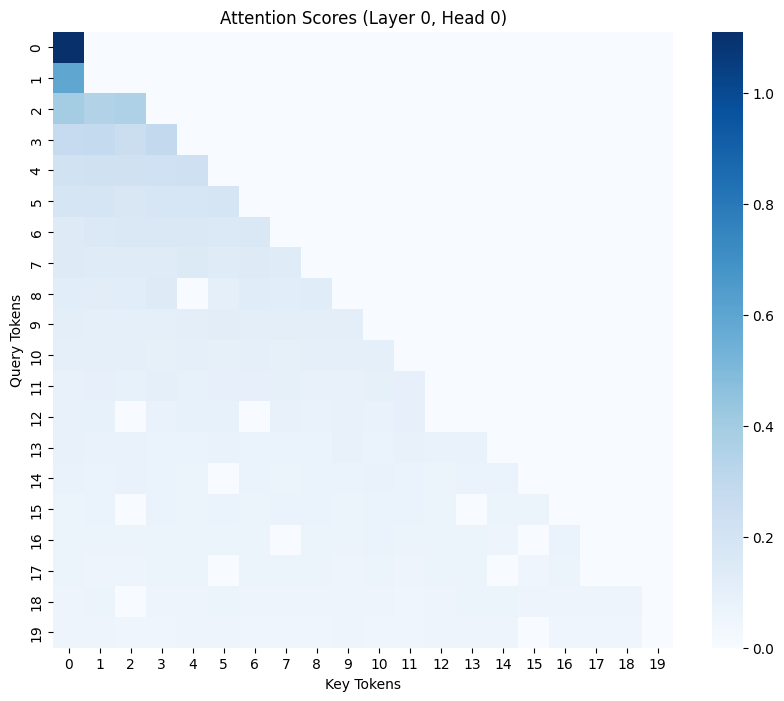

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize attention for the first head in the first layer
head_0 = layer_0_attentions[0, 0].detach().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(head_0, annot=False, cmap="Blues")
plt.title("Attention Scores (Layer 0, Head 0)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

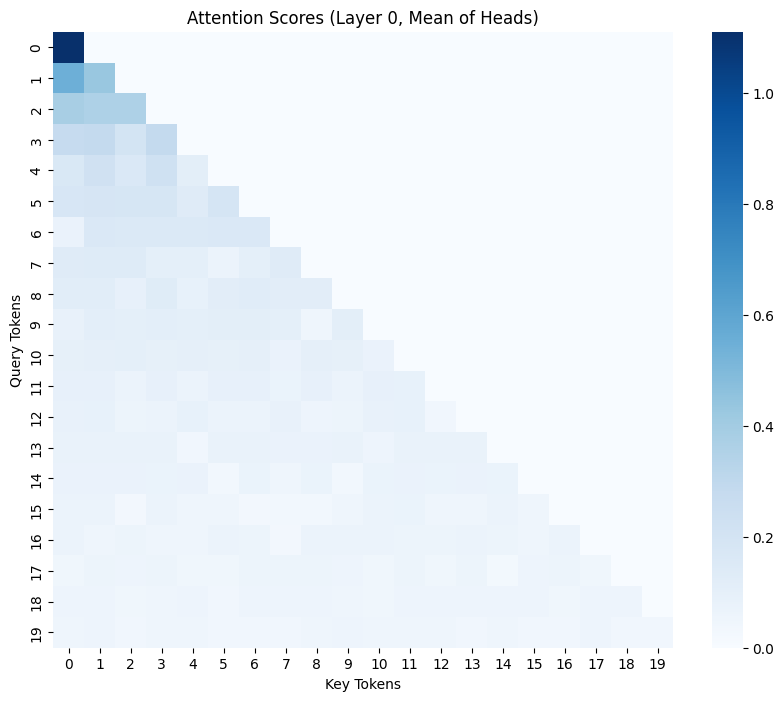

In [6]:
# function to get the mean head aggregation
def mean_head_aggregation(attentions):
    return attentions.mean(dim=1).detach().numpy()

# mean head aggregation
mean_head = mean_head_aggregation(layer_0_attentions)

plt.figure(figsize=(10, 8))
sns.heatmap(mean_head[0], annot=False, cmap="Blues")
plt.title("Attention Scores (Layer 0, Mean of Heads)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()


2. Convert attention to Graph

In [7]:
import networkx as nx
from torch_geometric.data import Data
import numpy as np

"""
Old way to create graph, changed so nodes are tokens and edges are attention weights

# Create the graph structure from the attention weights
def attention_to_graph(attention):
    # Get the number of nodes
    n = attention.shape[-1] # number of tokens

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes from attention
    for i in range(n):
        for j in range(n):
            if (j <= i): # attention masking
                G.add_node(f'token_{i}_att_{j}', weight=attention[i, j])
    
    # Agregate into toke level node
    for i in range(n):
        G.add_node(f'token_{i}', weight=1.0)
        for j in range(n):
            if (j <= i): # attention masking
                G.add_edge(f'token_{i}_att_{j}', f'token_{i}', weight=attention[i, j])

    # TODO: Check for further aggregation for transformer input

    return G
"""
# Create the graph structure from the attention weights
def attention_to_graph(attention):
    # Get the number of nodes
    n = attention.shape[-1] # number of tokens

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes from attention
    for i in range(n):
        # TODO: weight dependend on the number of the token
        G.add_node(f'token_{i}', weight=1.0)
    
    # Add edges from attention
    for i in range(n):
        for j in range(n):
            if (j <= i): # attention masking
                G.add_edge(f'token_{i}', f'token_{j}', weight=attention[i, j])

    # TODO: Check for further aggregation for transformer input

    return G

In [8]:
attention_matrix = torch.tensor([
        [0.1, 0.2, 0.3, 0.4],
        [0.5, 0.6, 0.7, 0.8],
        [0.9, 1.0, 1.1, 1.2],
        [1.3, 1.4, 1.5, 1.6]
    ])

attention_graph = attention_to_graph(attention_matrix)

def print_graph_details(G):
    print("Nodes:")
    for node, data in G.nodes(data=True):
        print(f"{node}: {data}")
    
    print("\nEdges:")
    for u, v, data in G.edges(data=True):
        print(f"{u} -> {v}: {data}")

print_graph_details(attention_graph)

Nodes:
token_0: {'weight': 1.0}
token_1: {'weight': 1.0}
token_2: {'weight': 1.0}
token_3: {'weight': 1.0}

Edges:
token_0 -> token_0: {'weight': tensor(0.1000)}
token_1 -> token_0: {'weight': tensor(0.5000)}
token_1 -> token_1: {'weight': tensor(0.6000)}
token_2 -> token_0: {'weight': tensor(0.9000)}
token_2 -> token_1: {'weight': tensor(1.)}
token_2 -> token_2: {'weight': tensor(1.1000)}
token_3 -> token_0: {'weight': tensor(1.3000)}
token_3 -> token_1: {'weight': tensor(1.4000)}
token_3 -> token_2: {'weight': tensor(1.5000)}
token_3 -> token_3: {'weight': tensor(1.6000)}


In [9]:
# Convert Attention Graph to PyTorch Geometric Data
mean_attention_graph = attention_to_graph(mean_head[0])
print_graph_details(mean_attention_graph)

Nodes:
token_0: {'weight': 1.0}
token_1: {'weight': 1.0}
token_2: {'weight': 1.0}
token_3: {'weight': 1.0}
token_4: {'weight': 1.0}
token_5: {'weight': 1.0}
token_6: {'weight': 1.0}
token_7: {'weight': 1.0}
token_8: {'weight': 1.0}
token_9: {'weight': 1.0}
token_10: {'weight': 1.0}
token_11: {'weight': 1.0}
token_12: {'weight': 1.0}
token_13: {'weight': 1.0}
token_14: {'weight': 1.0}
token_15: {'weight': 1.0}
token_16: {'weight': 1.0}
token_17: {'weight': 1.0}
token_18: {'weight': 1.0}
token_19: {'weight': 1.0}

Edges:
token_0 -> token_0: {'weight': np.float32(1.1111112)}
token_1 -> token_0: {'weight': np.float32(0.54944044)}
token_1 -> token_1: {'weight': np.float32(0.43261495)}
token_2 -> token_0: {'weight': np.float32(0.3847302)}
token_2 -> token_1: {'weight': np.float32(0.36258048)}
token_2 -> token_2: {'weight': np.float32(0.36380047)}
token_3 -> token_0: {'weight': np.float32(0.2789307)}
token_3 -> token_1: {'weight': np.float32(0.283713)}
token_3 -> token_2: {'weight': np.float3

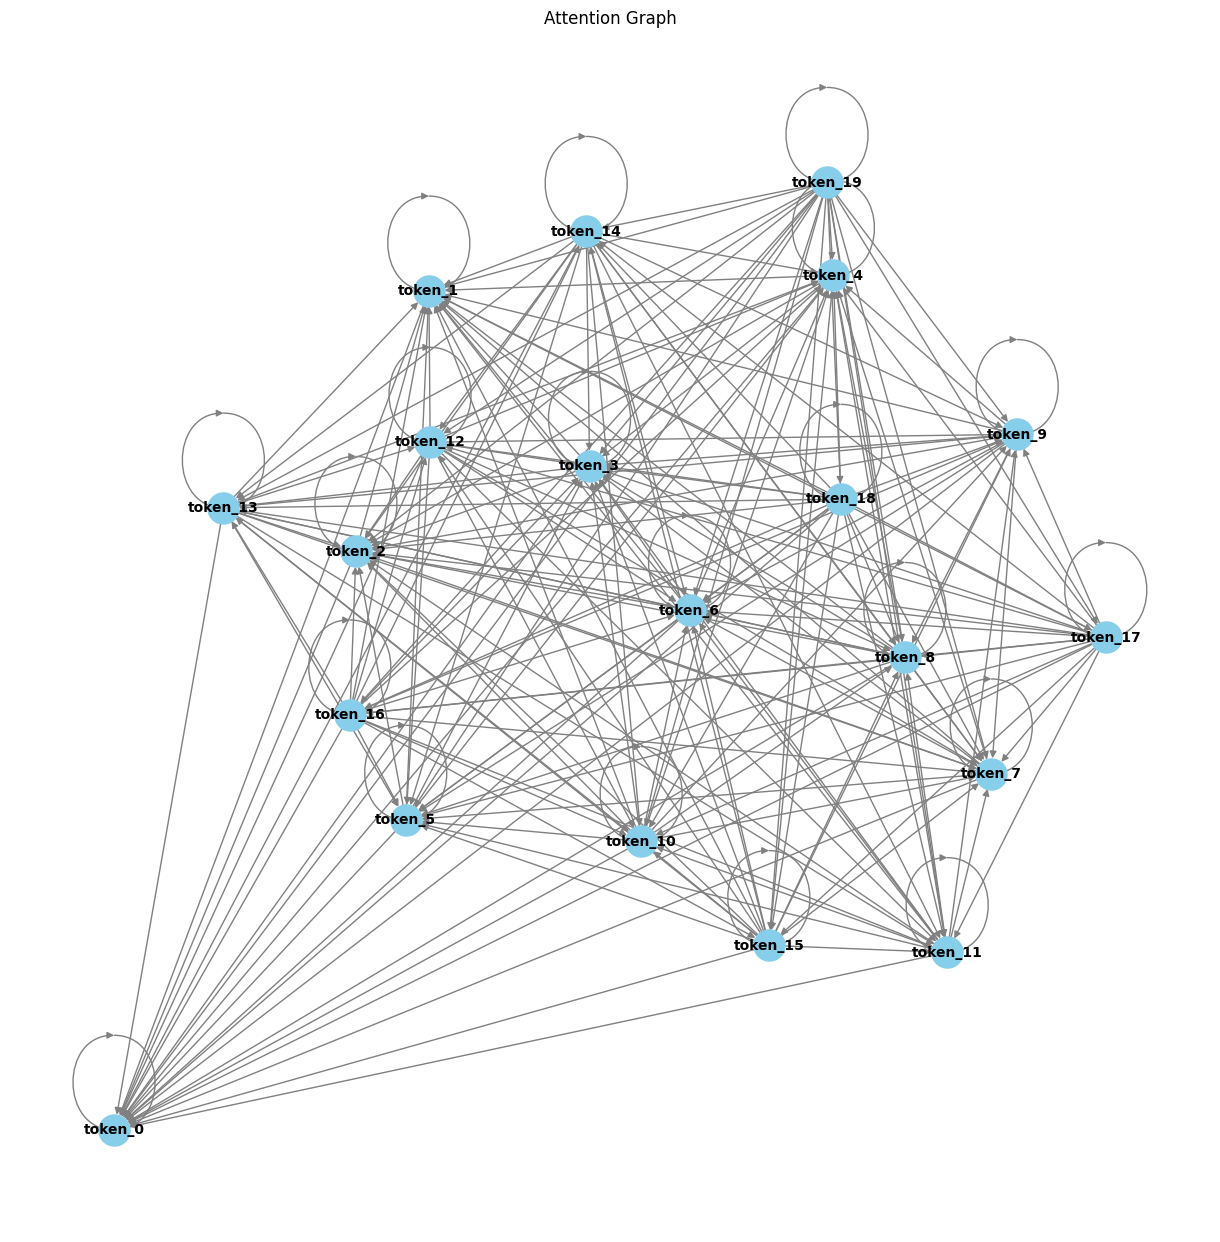

In [10]:
# Plotout the graph using matplotlib
import matplotlib.pyplot as plt

# Function to plot the graph
def plot_graph(G):
    pos = nx.spring_layout(G)  # Layout for visualization
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
    plt.title('Attention Graph')
    plt.show()

plot_graph(mean_attention_graph)

3. Create Graph NN
Used to aggregate information of the LLMs attention

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# data preparation for pytorch geometric
pyg_data = from_networkx(mean_attention_graph)
pyg_data.x = torch.ones(pyg_data.num_nodes, 1)  # TODO: Look for future improvements

In [12]:
# construct aggregation Network for the attention graph
# This network just compresses the data in the attnention mechanism for further processing
class AggregationNetwork(torch.nn.Module):
    def __init__(self, hidden_dim, dropout=0.2, adj_dropout=0.2): # TODO: hyperparameter tuning for dropout
        super(AggregationNetwork, self).__init__()
        self.conv1 = GCNConv(pyg_data.num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 1)
        self.dropout = torch.nn.Dropout(dropout)
        self.adj_dropout = adj_dropout
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        edge_index, edge_mask = pyg_utils.dropout_edge(edge_index, p=self.adj_dropout, training=self.training)

        if edge_weight is not None:
            edge_weight = edge_weight[edge_mask]

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        return x

In [13]:
# Test the aggregation network
hidden_dim_aggregation_nn = 64
aggregation_network = AggregationNetwork(hidden_dim_aggregation_nn)

# before training
print(pyg_data.x)
output_aggregation_nn = aggregation_network(pyg_data)
print(output_aggregation_nn.shape)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
torch.Size([20, 1])


4. Compression Network
Used to compress the information of the GNN for efficiency

In [14]:
# This compresses the attention graph into a smaller representation
class CompressionNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, compressed_dim, dropout=0.1):
        super(CompressionNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)  # Expand
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout)
        self.fc2 = torch.nn.Linear(hidden_dim, compressed_dim)  # Compress

    def forward(self, x):
        x = self.fc1(x)  # (num_tokens, 1) → (num_tokens, compressed_dim*2)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2 # (num_tokens, compressed_dim*2) → (num_tokens, compressed_dim)
        return x

In [15]:
# Test the compression network
hidden_dim_compression_nn = 64
compression_factor = 2 # TODO: hyperparameter tuning for compression factor
output_dim_compression_nn = output_aggregation_nn.shape[0] // compression_factor # rounds down
compression_network = CompressionNetwork(output_aggregation_nn.shape[0], hidden_dim_compression_nn, output_dim_compression_nn)

print(output_aggregation_nn.shape)
output_compression_nn = compression_network(output_aggregation_nn.view(1, -1)) # flatten the output
print(output_compression_nn)

torch.Size([20, 1])
Linear(in_features=64, out_features=10, bias=True)


5. Transformer for data processing

In [16]:
# Uses an encoder transfomer to link the different attention stages
class AggregationEncoderTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, dropout=0.1):
        super(AggregationEncoderTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(hidden_dim, input_dim)  # Output layer
        self.pos_encoder = nn.Parameter(torch.randn(1, 100, hidden_dim))  # Positional encoding

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoder[:, :x.size(1), :]  # Add positional encoding
        x = self.transformer_encoder(x)
        x = self.fc_out(x)
        return x

In [17]:
# Test the aggregation encoder transformer
input_dim_aggregation_encoder = output_dim_compression_nn # later output_dim_compression_nn * heads * num_layers
hidden_dim_aggregation_encoder = 64
num_heads_aggregation_encoder = 4
num_layers_aggregation_encoder = 2
aggregation_encoder = AggregationEncoderTransformer(input_dim_aggregation_encoder, hidden_dim_aggregation_encoder, num_heads_aggregation_encoder, num_layers_aggregation_encoder)

# example input for the transformer encoder
input_tensor = torch.rand(10).view(1, -1)  # (sequence_length)
input_tensor = input_tensor.unsqueeze(0)  # (1, sequence_length)
print(input_tensor.shape)
output_aggregation_encoder = aggregation_encoder(input_tensor)
print(output_aggregation_encoder.shape)  # (1, sequence_length, input_dim_aggregation_encoder)

torch.Size([1, 1, 10])
torch.Size([1, 1, 10])


c:\Users\leonh\anaconda3\envs\adverserialAlignment\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [18]:
# Tries to predict the current token from the attention graph
# This should allow to predict deviations from network intentions, during runtime
# And allow for better interpretability
class AttentionToRewardEncoder(nn.Module):
    def __init__(self, input_dim, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, dropout=0.1):
        super(AttentionToRewardEncoder, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)  # Project attention features
        self.pos_encoder = nn.Parameter(torch.randn(1, 100, d_model))  # Positional encoding

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        self.output_layer = nn.Linear(d_model, 1)  # Predict reward

    def forward(self, x):
        x = self.embedding(x)  
        x = x + self.pos_encoder[:, :x.size(1), :]  # Add positional info

        x = self.transformer_encoder(x)  # No causal mask needed
        x = x.mean(dim=1)  # Pool over token representations (global understanding)

        x = self.output_layer(x)  # Predict token logits  
        
        return x  # Output shape: (reward)


In [19]:
# Test the AttentionToTokenEncoder
encoder = AttentionToRewardEncoder(input_dim=output_compression_nn.shape[1])

input_tensor = torch.rand(10).view(1, -1)  # (sequence_length)
output = encoder(input_tensor)  # reward

print(output.shape)  # Expected output: float reward
print(output)

AttributeError: 'Linear' object has no attribute 'shape'

6. Create Math Dataset

In [ ]:
# imports
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer

# read in data from txt file
# Function to read problems and solutions
def load_math_data(problem_filename="math_problems.txt", solution_filename="math_solutions.txt"):
    problems = [line.strip() for line in open(problem_filename, "r")]
    solutions = [line.strip() for line in open(solution_filename, "r")]
    
    df = pd.DataFrame({"problem": problems, "solution": solutions})
    return df

data = load_math_data("math_problems.txt", "math_solutions.txt")

# PyTorch Dataset class
class MathDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=20):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        problem = self.dataframe.iloc[idx]["problem"]
        solution = self.dataframe.iloc[idx]["solution"]
        
        problem_enc = self.tokenizer(problem, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        
        return problem_enc['input_ids'].squeeze(0), solution

# Initialize GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
math_dataset = MathDataset(data, tokenizer, max_length=20)

data_loader = DataLoader(math_dataset, batch_size=1, shuffle=True)

In [ ]:
# Test the DataLoader
for batch in data_loader:
    problems, solutions = batch
    print("Problems:", problems)
    print("Solutions:", solutions)
    break  # Remove this break to iterate over the entire dataset

Problems: tensor([[38431,  1220,  1478, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]])
Solutions: ('47',)


In [ ]:
# Attention Reward Dataset
class AttentionRewardDataset(Dataset):
    def __init__(self, dataframe, max_length=20):
        self.dataframe = dataframe
        self.max_length = max_length
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        problem = self.dataframe.iloc[idx]["problem"]
        solution = self.dataframe.iloc[idx]["solution"]
        
        problem_enc = self.tokenizer(problem, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        solution_enc = self.tokenizer(solution, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        
        return problem_enc.input_ids.squeeze(), solution_enc.input_ids.squeeze()
    
    def extract_attention(self, model):
        # Extract attention from model
        pass

    def extract_results(self, model):
        # Extract results from model
        pass

    def new_datapoint(self, solution):
        # Add new datapoint
        pass

    def compute_reward_log_cosh(prediction, solution):
        """
        Compute the reward using the negative Log-Cosh error.
        """
        try:
            # Convert prediction and solution to tensors if they are not already
            prediction = torch.tensor(prediction, dtype=torch.float32)
            solution = torch.tensor(solution, dtype=torch.float32)
            
            # Compute the Log-Cosh error
            log_cosh = torch.log(torch.cosh(prediction - solution))
            
            # Return the negative Log-Cosh as the reward
            reward = -log_cosh.item()
        except Exception as e:
            print(f"Error computing reward: {e}")
            reward = -float('inf')  # Default to a very negative reward for invalid inputs
        
        return reward
        

7. Run the Model

In [ ]:
# Run the main model
for batch in data_loader:
    problems, solutions = batch
    print("Problems:", problems)
    print("Solutions:", solutions)
    
    # Forward pass through GPT-2
    outputs = model(problems)
    attentions = outputs.attentions
    print(f"Number of layers with attentions: {len(attentions)}")
    for i, layer_attention in enumerate(attentions):
        print(f"Layer {i} attention shape: {layer_attention.shape}")
    """
    # Extract attention activations
    layer_0_attentions = attentions[0]
    mean_head = mean_head_aggregation(layer_0_attentions)
    
    # Convert attention to graph
    attention_graph = attention_to_graph(mean_head[0])
    pyg_data = from_networkx(attention_graph)
    pyg_data.x = torch.ones(pyg_data.num_nodes, 1)
    
    # Aggregation Network
    output_aggregation_nn = aggregation_network(pyg_data)
    
    # Compression Network
    output_compression_nn = compression_network(output_aggregation_nn.view(1, -1))
    
    # AttentionToRewardEncoder
    reward = encoder(output_compression_nn)
    
    print("Reward:", reward)"
    """
    break  # Remove this break to iterate over the entire dataset

Problems: tensor([[ 1495,  1635,  6957, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]])
Solutions: ('2375',)
Number of layers with attentions: 4
Layer 0 attention shape: torch.Size([1, 4, 20, 20])
Layer 1 attention shape: torch.Size([1, 4, 20, 20])
Layer 2 attention shape: torch.Size([1, 4, 20, 20])
Layer 3 attention shape: torch.Size([1, 4, 20, 20])


In [27]:
# Datagenerator for attention reward dataset
# test creation with JSON file
import json
import numpy as np

# example JSON data
rewardDatasetTest = [
    { "attention": np.random.rand(4, 4, 20, 20).tolist(), "reward": np.random.rand(1).tolist() } for _ in range(100) # layers, heads, tokens, tokens
]

with open('rewardDatasetTest.json', 'w') as f:
    json.dump(rewardDatasetTest, f)

In [ ]:
# create data from the primary model
problems, solutions = batch
    print("Problems:", problems)
    print("Solutions:", solutions)
    
    # Forward pass through GPT-2
    outputs = model(problems)
    attentions = outputs.attentions
    print(f"Number of layers with attentions: {len(attentions)}")
    for i, layer_attention in enumerate(attentions):
        print(f"Layer {i} attention shape: {layer_attention.shape}")

    break

In [28]:
from torch.utils.data import Dataset, DataLoader

# Load JSON
class AttentionRewardDatasetJSON(Dataset):
    def __init__(self, json_file):
        with open(json_file, "r") as f:
            self.data = json.load(f)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        attention = np.array(self.data[idx]["attention"])
        reward = self.data[idx]["reward"]
        return attention, reward

In [29]:
dataloader_json = DataLoader(AttentionRewardDatasetJSON("rewardDatasetTest.json"), batch_size=1, shuffle=True)

In [30]:
# Test the DataLoader
for batch in dataloader_json:
    problems, solutions = batch
    print("Problems:", problems)
    print("Solutions:", solutions)
    break  # Remove this break to iterate over the entire dataset

Problems: tensor([[[[[3.0380e-01, 2.3166e-01, 5.2597e-01,  ..., 8.7203e-01,
            7.7647e-01, 7.7505e-01],
           [5.3653e-02, 7.1952e-01, 6.9290e-01,  ..., 6.8499e-01,
            9.2566e-01, 4.2972e-01],
           [6.1515e-02, 5.6840e-01, 1.8519e-03,  ..., 2.4384e-01,
            6.4203e-01, 2.6044e-01],
           ...,
           [1.7962e-01, 4.3254e-01, 4.2665e-01,  ..., 2.7257e-01,
            6.7887e-01, 3.7160e-01],
           [9.3757e-01, 8.8059e-01, 8.5640e-01,  ..., 2.5624e-01,
            8.5564e-01, 7.2484e-01],
           [2.3196e-01, 9.0107e-01, 5.4261e-01,  ..., 3.9075e-01,
            4.4652e-01, 7.2334e-01]],

          [[5.8384e-01, 8.6779e-01, 4.2184e-01,  ..., 2.2098e-01,
            3.2279e-01, 1.4427e-01],
           [8.8108e-01, 5.2631e-02, 7.1367e-01,  ..., 3.2777e-02,
            4.2430e-01, 1.6642e-01],
           [4.2793e-01, 9.4816e-01, 4.9203e-01,  ..., 6.1907e-01,
            5.0752e-01, 3.3799e-01],
           ...,
           [8.3323e-01, 7.766

In [ ]:
# function to get the mean head aggregation
def mean_var_head_aggregation(attentions):
    aggregated_attention = attentions.mean(dim=1).detach().numpy() + attentions.var(axis=1).detach().numpy()
    return aggregated_attention

In [ ]:
def print_attention_head(attention_head):    
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_head[0], annot=False, cmap="Blues")
    plt.title("Attention Scores (Layer 0, Mean of Heads)")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()
    return

(1, 20, 20)


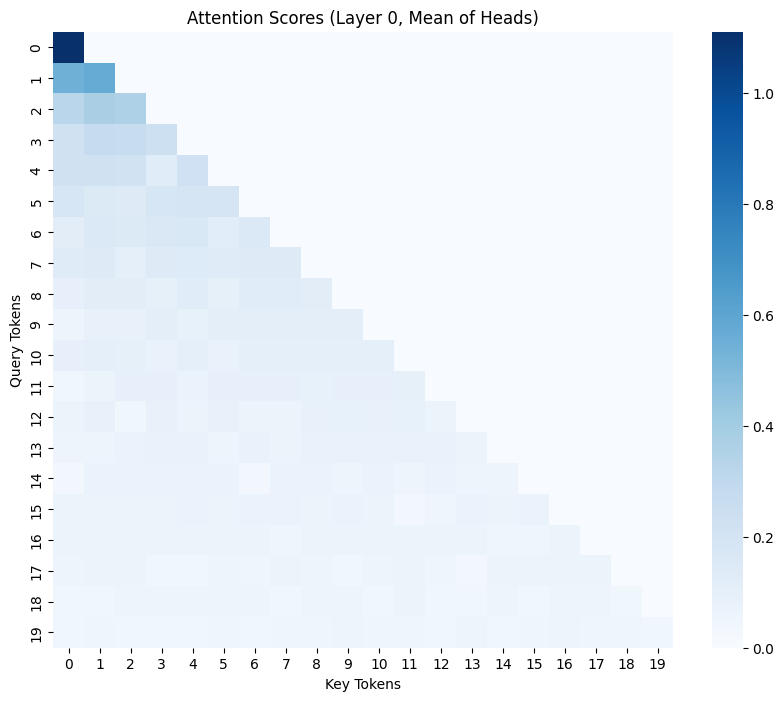

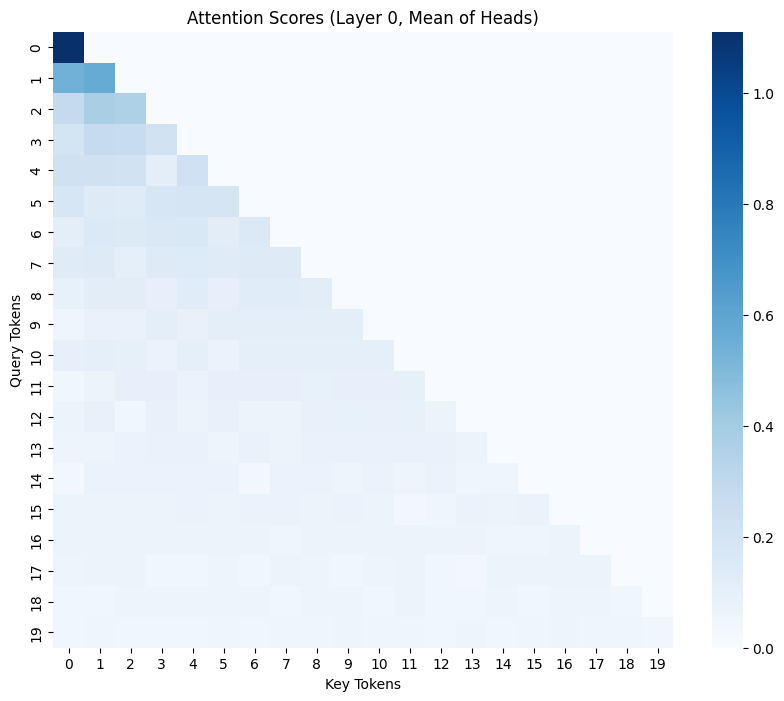

In [ ]:
print(mean_var_head_aggregation(attentions[0]).shape)
print_attention_head(mean_var_head_aggregation(attentions[0]))
print_attention_head(mean_head_aggregation(attentions[0]))